In [1]:
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt



# Read the data using pandas library
# Using 90% of the data as training data and the remaining 10% as testing data
data = pd.read_csv('heart.csv')
msk = np.random.rand(len(data)) < 0.9 
df = data[msk]
tf = data[~msk]



attributes = list(df.columns)

In [2]:
# Take in the rows and a question and split the rows based on that question
def partition(rows, question):
    """Partitions a dataset.
    Locate the rows that are greater than the value in a certain column
    """
    true_rows, false_rows = [], []
    # Get question attributes
    col,val = question[0],question[1]
    # Locate the rows that meet quesiton criteria and those that don't
    true_rows = rows.loc[rows[attributes[col]]>=val]
    false_rows = rows.loc[rows[attributes[col]]<val]
    # Return the sets of rows
    return true_rows, false_rows

In [3]:
# Calculate the gini impurity of the rows
def gini(rows):
    # Find how many have overall attribute 
    yes = rows.loc[rows[attributes[0]]==1].shape[0]
    # Get total number of rows
    total = rows.shape[0]
    impurity = 1-(yes/total)**2-((total-yes)/total)**2
    return impurity


In [4]:
# Determine information gain given the left and right rows and the uncertainty of the current row
def info_gain(left, right, current_uncertainty):
    p = float(len(left)) / (len(left) + len(right))
    return current_uncertainty - p * gini(left) - (1 - p) * gini(right)

In [5]:
# Find the best place to split the rows
def find_best_split(rows):
    best_gain = 0  # keep track of the best information gain
    best_question = None  # keep train of the feature / value that produced it
    current_uncertainty = gini(rows)
    num_attributes = len(attributes)-1 # get number of attributes
    num_rows = rows.shape[0]

    for col in range(num_attributes):  # for each feature
        rows.sort_values(by=attributes[col+1],ascending = True)
        for row in range(num_rows-2):  # for each row
            lower = (df.iloc[row])[col+1]
            upper = (df.iloc[row+1])[col+1]
            avg = (lower+upper)/2
            question = (col+1,avg) # Create a question using the average of consecutive rows

            # try splitting the dataset
            true_rows, false_rows = partition(rows, question)
  
            # Skip this split if it doesn't divide the
            # dataset.
            if len(true_rows) == 0 or len(false_rows) == 0:
                continue
            
            # Calculate the information gain from this split
            gain = info_gain(true_rows, false_rows, current_uncertainty)

            if gain >= best_gain:
                best_gain, best_question = gain, question

    return best_gain, best_question

In [6]:
# Leaf node that holds the dicionary of a class and the number of times it appears in 
# the rows from the training data reaching this leaf
class Leaf:

    def __init__(self, rows):
        yes = rows.loc[rows[attributes[0]]==1].shape[0]
        no = rows.loc[rows[attributes[0]]==0].shape[0]
        self.predictions = (yes,no)

In [7]:
# Asks a question and holds a reference to a question and two child nodes
class Decision_Node:

    def __init__(self,question,true_branch,false_branch):
        self.question = question
        self.true_branch = true_branch
        self.false_branch = false_branch        
        

In [8]:
# Build the tree
def build_tree(rows,depth,max_depth):

    # Try partitioning the dataset on each of the unique attribute,
    # calculate the information gain,
    # and return the question that produces the highest gain.
    gain, question = find_best_split(rows)

    # Base case: no further info gain
    # Since we can ask no further questions,
    # we'll return a leaf.
    if gain == 0 or depth>=max_depth:
        return Leaf(rows)

    # If we reach here, we have found a useful feature / value
    # to partition on.
    true_rows, false_rows = partition(rows, question)

    # Recursively build the true branch.
    true_branch = build_tree(true_rows,depth+1,max_depth)

    # Recursively build the false branch.
    false_branch = build_tree(false_rows,depth+1,max_depth)

    # Return a Question node.
    return Decision_Node(question, true_branch, false_branch)

In [9]:
# Given a number of rows with yesses and nos determine what the prediction should be
def predict(prediction):
    if prediction[0]>=prediction[1]:
        return 1
    else:
        return 0

In [10]:
# Prints the tree (based off online availible code)
def print_tree(node, spacing=""):

    # Base case: we've reached a leaf
    if isinstance(node, Leaf):
        pred = predict(node.predictions)
        if pred == 1:
            decision = "TRUE"
        else:
            decision = "FALSE"
        print (spacing + "Predict", decision)
        return

    # Print the question at this node
    print(spacing + attributes[node.question[0]]+' >= '+str(node.question[1]))

    # Call this function recursively on the true branch
    print (spacing + '--> True:')
    print_tree(node.true_branch, spacing + "  ")

    # Call this function recursively on the false branch
    print (spacing + '--> False:')
    print_tree(node.false_branch, spacing + "  ")

In [11]:
# Find a predicted yesses and nos of certain leaf nodes
def classify(row, node):

    # Base case: we've reached a leaf
    if isinstance(node, Leaf):
        return node.predictions

    # Decide whether to follow the true-branch or the false-branch.
    # Compare the feature / value stored in the node,
    # to the example we're considering.
    col = node.question[0]
    val = node.question[1]
    if row[col]>=val:
        return classify(row, node.true_branch)
    else:
        return classify(row, node.false_branch)

In [12]:
# Loop through test data and match prediction to actual values
def classify_test(tree,rows):
    x = 0
    for i in range(rows.shape[0]):
        prediction = predict(classify(rows.iloc[i],tree))
        if prediction == rows.iloc[i][0]:
            x+=1
    # Return the overall acuracy of the decision tree using the test data        
    return (x/rows.shape[0])

In [13]:
# Create an array of trees with varying max depths
tic = time.time()
max_depths = 5
trees = []
for i in range(1,max_depths+1):
    my_tree = build_tree(df,0,i)
    trees.append(my_tree)
toc = time.time()
# Show the time
print('Time: '+str(int(toc-tic))+'s')

# Print the second tree in the array
print_tree(trees[1])

Time: 116s
cp >= 1.0
--> True:
  age >= 57.0
  --> True:
    Predict TRUE
  --> False:
    Predict TRUE
--> False:
  ca >= 1.0
  --> True:
    Predict FALSE
  --> False:
    Predict TRUE


   Max Depth  Accuracy
1        1.0  0.750000
2        2.0  0.704545
3        3.0  0.840909
4        4.0  0.795455
5        5.0  0.863636


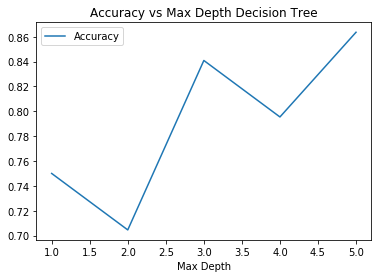

In [14]:
# Create chart to check how max depth affects accuracy of the decision tree
# using the remaing rows as testing data
d = {'Max Depth':[],'Accuracy': []}
pf = pd.DataFrame(data=d)
i = 1
accuracies = []
for tree in trees:
    accuracy = classify_test(tree,tf)
    accuracies.append(accuracy)
    pf.loc[i] = int(i),accuracy
    i+=1

ax = plt.gca()
plt.title('Accuracy vs Max Depth Decision Tree')
pf.plot(kind='line',x='Max Depth',y='Accuracy',ax=ax)

print(pf)